# Artificial data

Methods:
1. Mutual Information
2. Chi2 test
3. Random Forest features importance
4. Boruta (with Random Forest) + removing correlated features

For each method, an XGBoost classifier was trained on the selected features and the accuracy was calculated. This model was chosen after performing initial experiments to compare different models.

Finally, for each method, different number of features was considered and then the best was selected manually based on accuracy plots.

Settings for XGboost models (same for all methods).

In [1]:
from xgboost import XGBClassifier
model = XGBClassifier
model_params_dict = {
    'n_estimators': 100,
    'max_depth': 7,
    'random_state': 42
}

All functions and experiments parameters.

In [2]:
from utils import *

desired_features = 5
features_min = 1
features_max = 25
step = 1

dataset_name = 'artificial'
model_name = 'XGBoost'

Load and split data.

In [3]:
X_train, X_valid, y_train, y_valid, artificial_test = load_artificial()

Store best results for each method.

In [4]:
final_results = []

## Mutual information

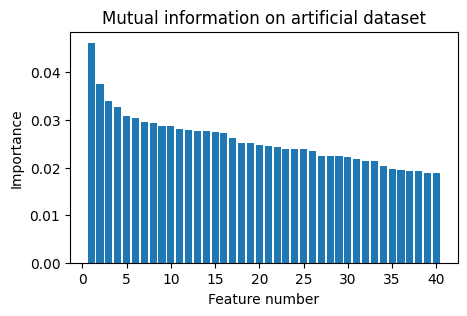

100%|██████████| 24/24 [00:08<00:00,  2.99it/s]


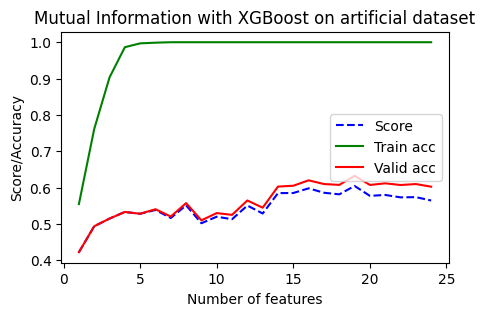

In [5]:
method_name = 'Mutual information'

importances = get_importance_mutual_information(X_train, y_train)
plot_first_k_percent_importances(importances, f'{method_name} on {dataset_name} dataset', 8)
results_df = get_results_df_by_features(importances, model, model_params_dict, 
                                        X_train, y_train, X_valid, y_valid, 
                                        desired_features, features_min, features_max, step)
make_plot_by_features(results_df, f'Mutual Information with {model_name} on {dataset_name} dataset')

In [6]:
min_features = 12
max_features = 15

final_results.append(print_results_for_specific_features(results_df, min_features, max_features, method_name))

    Features     Score  Train acc  Valid acc
14        15  0.585136        1.0   0.605136


## Chi2 test

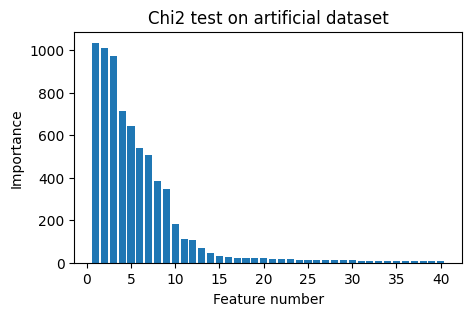

100%|██████████| 24/24 [00:06<00:00,  3.65it/s]


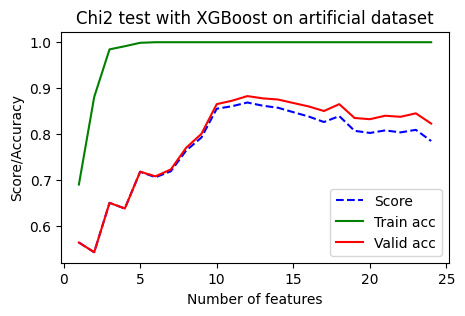

In [7]:
method_name = 'Chi2 test'
importances = get_importance_chi2(X_train, y_train)
plot_first_k_percent_importances(importances, f'{method_name} on {dataset_name} dataset', 8)
results_df = get_results_df_by_features(importances, model, model_params_dict, 
                                        X_train, y_train, X_valid, y_valid, 
                                        desired_features, features_min, features_max, step)
make_plot_by_features(results_df, f'Chi2 test with {model_name} on {dataset_name} dataset')

In [8]:
min_features = 9
max_features = 13

final_results.append(print_results_for_specific_features(results_df, min_features, max_features, method_name))

    Features     Score  Train acc  Valid acc
11        12  0.868511        1.0   0.882511


## Random Forest features importance

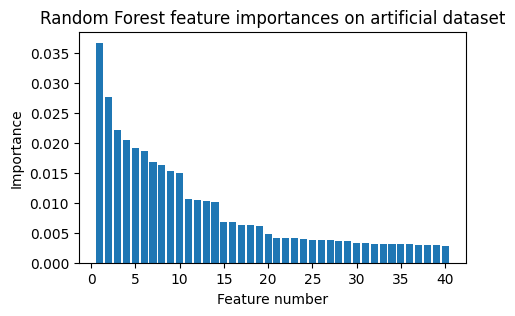

100%|██████████| 24/24 [00:06<00:00,  3.85it/s]


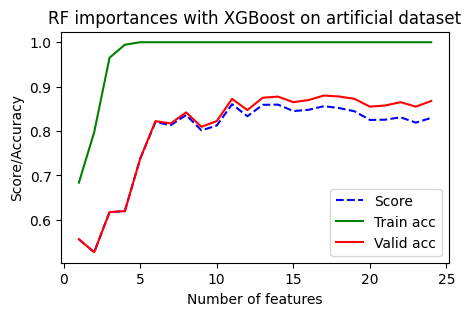

In [9]:
method_name = 'Random Forest'
importances = get_importance_random_forest(X_train, y_train)
plot_first_k_percent_importances(importances, f'{method_name} feature importances on {dataset_name} dataset', k=8)
results_df = get_results_df_by_features(importances, model, model_params_dict, 
                                        X_train, y_train, X_valid, y_valid, 
                                        desired_features, features_min, features_max, step)
make_plot_by_features(results_df, f'RF importances with {model_name} on {dataset_name} dataset')

In [10]:
min_features = 5
max_features = 13

final_results.append(print_results_for_specific_features(results_df, min_features, max_features, method_name))

    Features     Score  Train acc  Valid acc
10        11  0.860434        1.0   0.872434


## Boruta

Number of selected features: 21


100%|██████████| 21/21 [00:05<00:00,  3.97it/s]


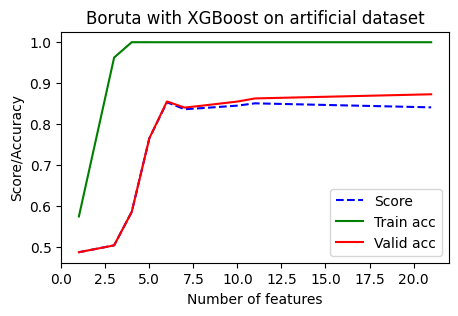

In [11]:
method_name = 'Boruta'
importances = get_importance_boruta(X_train, y_train)
results_df = get_results_df_by_features_boruta(importances, model, model_params_dict, 
                                        X_train, y_train, X_valid, y_valid, 
                                        desired_features, features_min, features_max, step)
make_plot_by_features(results_df, f'{method_name} with {model_name} on {dataset_name} dataset')

In [12]:
min_features = 5
max_features = 10

final_results.append(print_results_for_specific_features(results_df, min_features, max_features, method_name))

    Features     Score  Train acc  Valid acc
11         6  0.853042        1.0   0.855042


# Summary

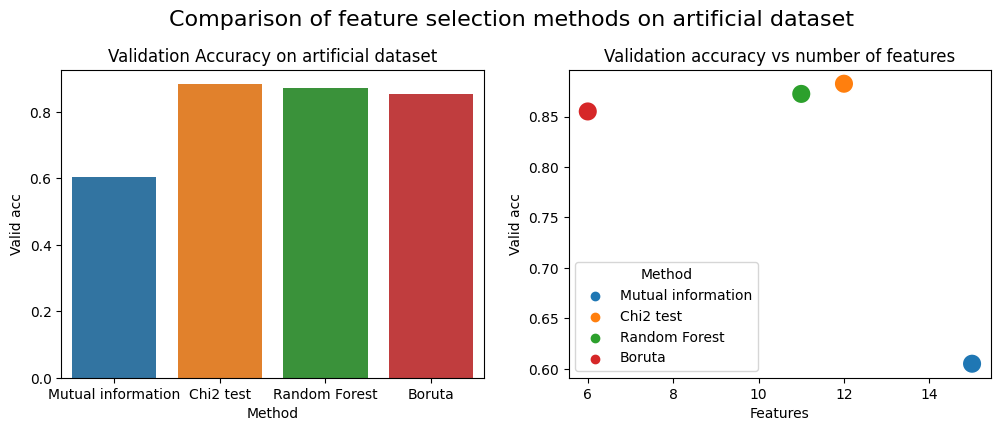

In [13]:
plot_summary(final_results, dataset_name)

# Saving predictions

For Boruta - the fewest features with high accuracy.

In [14]:
save_predictions(final_results, 'Boruta', dataset_name, artificial_test)

Predictions saved to file
Features saved to file (there are 6 features):
[ 28  48  64 153 204 453]
